
# Beat tracking with time-varying tempo

This notebook demonstrates how to use the beat tracker in situations where the tempo
may change over time.

By default, the beat tracking algorithm [1]_ estimates a single tempo for the entire
signal, though it does tolerate small amounts of fluctuation around that tempo.
This is well suited for songs that have an approximately constant tempo, but where
individual beats may not be exactly spaced accordingly.
It is not well suited for songs that have radical shifts in tempo, e.g., entire sections
that speed up or slow down, or gradual accelerations over long periods of time.

The implementation in librosa (``librosa.beat.beat_track``) extends this algorithm
to support different tempo estimates at each time point in the signal, as
demonstrated below.

.. [1] Ellis, Daniel PW. "Beat tracking by dynamic programming."
       Journal of New Music Research 36, no. 1 (2007): 51-60.
       http://labrosa.ee.columbia.edu/projects/beattrack/


In [1]:
# Code source: Brian McFee
# License: ISC

import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

## A recording with dynamic tempo
The example recording included in this notebook consists of a drum beat that
gradually increases in tempo from 30 BPM to 240 BPM over a 30-second time interval.



In [3]:
audio_1 = 'audio/Acordai-80.mp3'
audio_2 = 'audio/Acordai-90.mp3'
y, sr = librosa.load(audio_1)

We can visualize the spectrogram of this recording and listen to it.
From the spectrogram, we can see that the spacing between drum beats becomes
smaller over time, indicating a gradual increase of tempo.



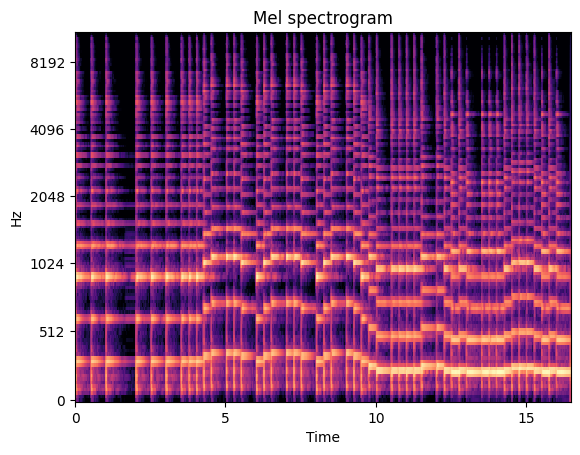

In [4]:
fig, ax = plt.subplots()
melspec = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr), ref=np.max)
librosa.display.specshow(melspec, y_axis='mel', x_axis='time', ax=ax)
ax.set(title='Mel spectrogram')

Audio(data=y, rate=sr)

## Static tempo beat tracking
If we run the beat tracker on this signal directly and sonify the result as a click
track, we can see that it does not follow particularly well.
This is because the beat tracker is assuming a single (average) tempo across the
entire signal.
Note: by default, `beat_track` assumes that there is silence at the end of the
signal, and trims last beats to avoid false detections. Here, there is no silence
at the end, so we set `trim=False` to avoid this effect.



In [5]:
tempo, beats_static = librosa.beat.beat_track(y=y, sr=sr, units='time', trim=True)

click_track = librosa.clicks(times=beats_static, sr=sr, click_freq=660, click_duration=0.25, length=len(y))

print(f"Tempo estimate: {tempo[0]:.2f} BPM")
Audio(data=y+click_track, rate=sr)

Tempo estimate: 123.05 BPM


## Dynamic tempo
Instead of estimating an aggregated tempo for the whole signal, we now estimate
a time-varying tempo. For this purpose, we pass `aggregate=None` to
`librosa.feature.tempo`. The return value tempo_dynamic, is an array:



In [6]:
tempo_dynamic = librosa.feature.tempo(y=y, sr=sr, aggregate=None, std_bpm=4)

The parameter `std_bpm` is the standard deviation of the tempo estimator and
has a default value of 1. Here, we have increased `std_bpm` to 4.
This is to account for the broad range of tempo drift in this
particular recording (30 BPM to 240 BPM).
We can plot the dynamic and static tempo estimates to see how they differ.



[Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'Tempo (BPM)')]

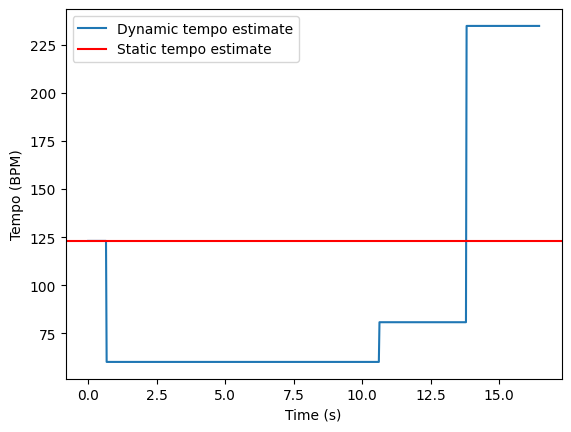

In [7]:
fig, ax = plt.subplots()
times = librosa.times_like(tempo_dynamic, sr=sr)
ax.plot(times, tempo_dynamic, label='Dynamic tempo estimate')
ax.axhline(tempo, label='Static tempo estimate', color='r')
ax.legend()
ax.set(xlabel='Time (s)', ylabel='Tempo (BPM)')

`librosa.feature.tempo` estimates tempo over a sliding window whose duration
`ac_size` is equal to 8 seconds by default.
In this example, the result is not perfect: `tempo_dynamic` contains jagged and
nonuniform steps.
However, it does provide a rough picture of how tempo is changing over time.

We can now use this dynamic tempo in the beat tracker directly:



In [8]:
tempo, beats_dynamic = librosa.beat.beat_track(y=y, sr=sr, units='time',
                                               bpm=tempo_dynamic, trim=False)

click_dynamic = librosa.clicks(times=beats_dynamic, sr=sr, click_freq=660,
                               click_duration=0.25, length=len(y))

Audio(data=y+click_dynamic, rate=sr)

(Note that since we're providing the tempo estimates as input to the beat tracker,
we can ignore the first return value (`tempo`) which will simply be a copy of the
input (`tempo_dynamic`).)

We can visualize the difference in estimated beat timings as follows:



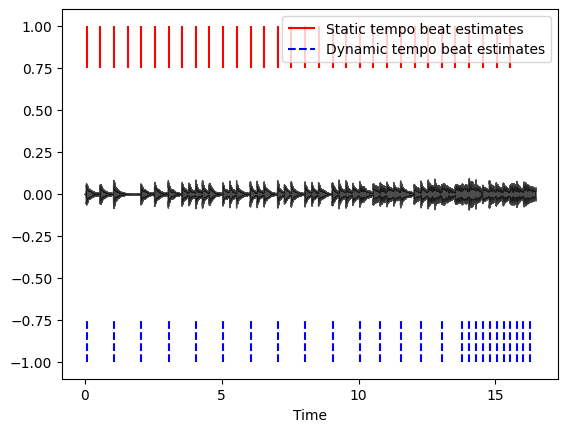

In [9]:
fig, ax = plt.subplots()
librosa.display.waveshow(y=y, sr=sr, ax=ax, color='k', alpha=0.7)
ax.vlines(beats_static, 0.75, 1., label='Static tempo beat estimates', color='r')
ax.vlines(beats_dynamic, -1, -0.75, label='Dynamic tempo beat estimates', color='b', linestyle='--')
ax.legend()

In the figure above, we observe that `beats_dynamic`, the beat estimates derived
from dynamic tempo, align well to the audio recording.
On the contrary, `beats_static` suffers from alignment problems.
Indeed, it has too many detections towards the beginning of the recording—where
the static tempo estimate is too fast—and too few detections towards the end of
the recording—where the static tempo estimate is too slow.

